# **Maintanane prediction - pump sensor data** <br>
Link to Kaggle: https://www.kaggle.com/nphantawee/pump-sensor-data

**I Classification problem** - accident within a period of time <br>
**II Regression problem** - RUL - Remaining Useful Time estimation

**Step 1** <br>
Look through data, prepare data

In [15]:
import pandas as pd 
import numpy as np

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [17]:
import matplotlib.pyplot as plt

In [18]:
import_raw = pd.read_csv(r'D:\PROJEKTY\pump_sensor\sensor.csv', index_col=0)

In [19]:
import_raw.head(2)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,41.92708,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,243.0556,201.3889,NORMAL


In [20]:
#import_raw.info()

In [21]:
#import_raw.describe()

In [22]:
#drop sensor_15 column - only NaN value
try:
    import_raw.drop(['sensor_15'], axis=1, inplace=True)
except KeyError as e:
    print("Column does not exist:  ", str(e))

In [23]:
# Check for different machine statuses
import_raw['machine_status'].unique()

array(['NORMAL', 'BROKEN', 'RECOVERING'], dtype=object)

In [24]:
import_raw.machine_status.value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [25]:
#import_raw.isna().sum()

In [26]:
import_data_missing = import_raw.isna()
import_data_missing_num = import_data_missing.sum()

In [27]:
import_data_missing_percentage = ((import_data_missing_num / len(import_raw))*100).to_frame()

In [28]:
import_data_missing_percentage.transpose()

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0.0,4.633261,0.167484,0.008624,0.008624,0.008624,0.008624,2.177741,2.474129,2.317992,...,0.012255,0.012255,0.012255,0.012255,0.012255,0.012255,0.012255,34.956881,6.982117,0.0


In [29]:
# ~35% of missing in sensor_50
sensor_50 = import_raw[['sensor_50']]
sensor_50.fillna(value={'sensor_50':'2000'}, inplace=True)

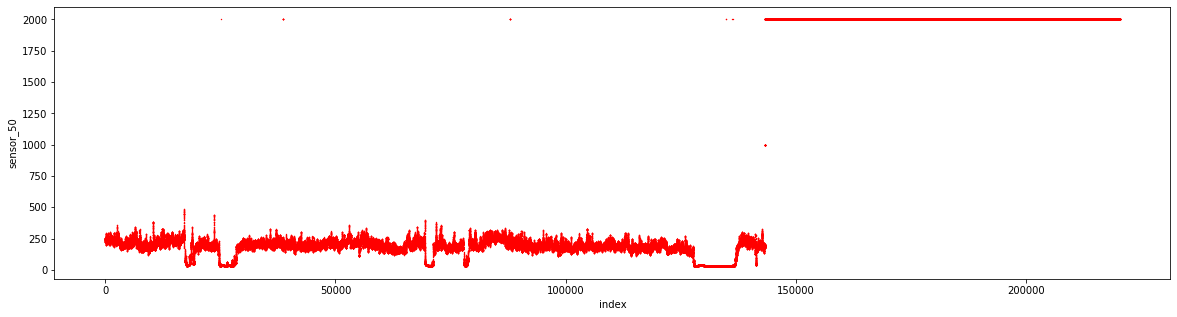

In [30]:
# after changing NA to some outstanding value, I decide to remove this variable
plt.figure(figsize=(20,5))
plt.scatter(sensor_50.index, sensor_50.sensor_50, s=0.2, c='r', marker='x')
plt.xlabel('index')
plt.ylabel('sensor_50')
plt.show()

In [31]:
#drop sensor_15 column - only NaN value
try:
    import_raw.drop(['sensor_50'], axis=1, inplace=True)
except KeyError as e:
    print("Column does not exist:  ", str(e))

In [32]:
def draw_sensor_data(sensor_number, import_raw):
    plt.figure(figsize=(20,5))
    sensor_num = 'sensor_' + str(sensor_number)
    plt.scatter(import_raw.index, import_raw[[sensor_num]], s=0.2, c='r', marker='x')
    plt.xlabel('index')
    plt.ylabel(sensor_num)
    plt.show()

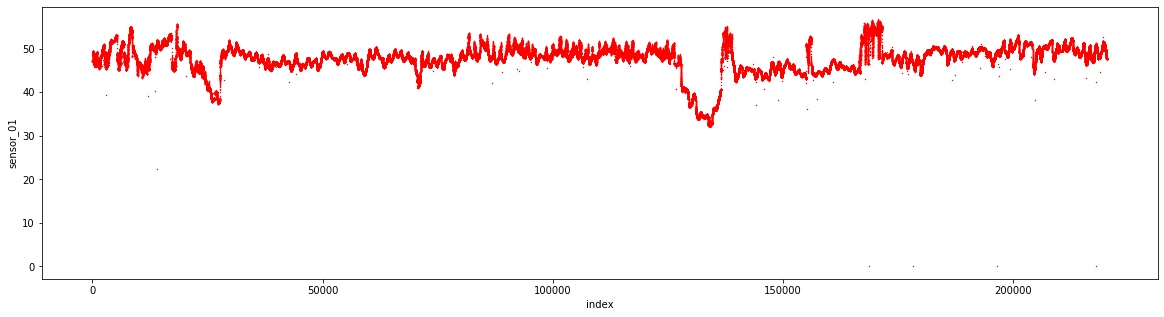

In [33]:
draw_sensor_data('01', import_raw)

In [34]:
# Lets check how different states ('NORMAL', 'BROKEN', 'RECOVERING') occur over time
# Replace string with numerical representation
# Normal=1, Broken=2, Recovering=3
machine_status = import_raw[['machine_status']]
machine_status.loc[machine_status['machine_status'] == 'NORMAL'] = 1
machine_status.loc[machine_status['machine_status'] == 'BROKEN'] = 2
machine_status.loc[machine_status['machine_status'] == 'RECOVERING'] = 3

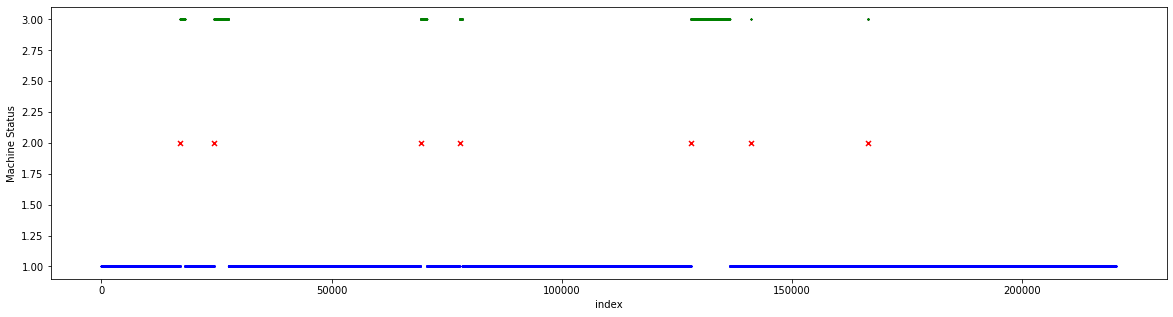

In [35]:
plt.figure(figsize=(20,5))
plt.scatter(machine_status.index, machine_status.where(machine_status['machine_status']==1), s=0.1, c='b', marker='x')
plt.scatter(machine_status.index, machine_status.where(machine_status['machine_status']==2), s=25, c='r', marker='x')
plt.scatter(machine_status.index, machine_status.where(machine_status['machine_status']==3), s=0.1, c='g', marker='x')
plt.xlabel('index')
plt.ylabel('Machine Status')
plt.show()

In [36]:
# After looking at sensor values visualisations - it looks at the first sight that 'outsiders' values may be connected with breakdown in machines work
# I've decided to replace missing values with AKIMA interpolation

In [37]:
sensors_df_akima = import_raw.copy()

In [38]:
sensors_df_akima.interpolate(method='akima', inplace=True)

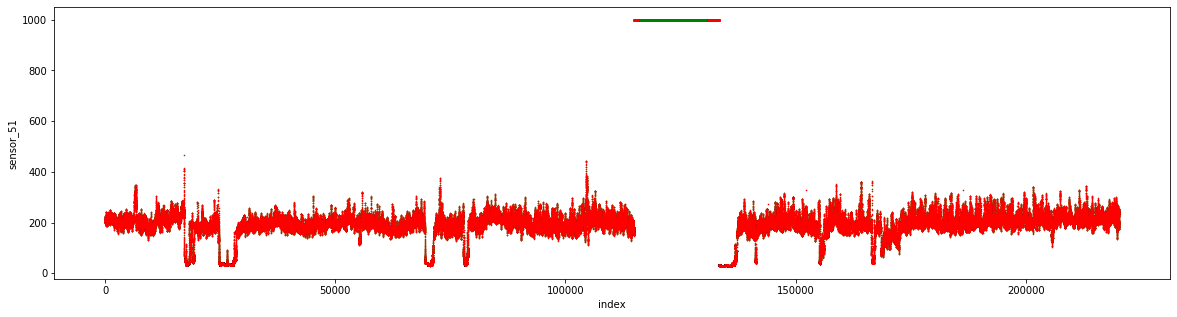

In [39]:
sensor_num = '51' 
plt.figure(figsize=(20,5))
sensor_num = 'sensor_' + str(sensor_num)
plt.scatter(sensors_df_akima.index, sensors_df_akima[[sensor_num]], s=0.2, c='g', marker='x')
plt.scatter(import_raw.index, import_raw[[sensor_num]], s=0.2, c='r', marker='x')
plt.xlabel('index')
plt.ylabel(sensor_num)
plt.show()

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
one_hot_encoder = OneHotEncoder()
one_hot_encoded = one_hot_encoder.fit_transform(sensors_df_akima[['machine_status']]).toarray()

In [42]:
sensors_df_akima_one_hot = pd.DataFrame(one_hot_encoded, columns=one_hot_encoder.get_feature_names().tolist())

In [43]:
sensors_df_akima_one_hot.head()

,x0_BROKEN,x0_NORMAL,x0_RECOVERING
0,0.0,1.0,0.0
1,0.0,1.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,1.0,0.0


In [44]:
#replace categorical column with one hot encoded
try:
    sensors_df_akima.drop(['machine_status'], axis=1, inplace=True)
except KeyError as e:
    print("Column does not exist:  ", str(e))
    
#inner join tables on index

#make sure arrays have the same number of rows
if sensors_df_akima.shape[0] == sensors_df_akima_one_hot.shape[0]:
    sensors_df_akima = pd.concat([sensors_df_akima, sensors_df_akima_one_hot], axis=1, join='inner')
else:
    print("Different number of rows.")

In [45]:
sensors_df_akima.head(2)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,x0_BROKEN,x0_NORMAL,x0_RECOVERING
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,201.3889,0.0,1.0,0.0
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,201.3889,0.0,1.0,0.0


**Let's perform some PCA analysis to see the distribution of variance** <br>
**Also let's check how existing features imply on the state of machine - Random Forest Classifier** <br>
Afterwards some feature engineering will be required

In [46]:
from sklearn.decomposition import PCA

In [47]:
def display_PCA(n_components):
    model = PCA(n_components)
    model.fit_transform(sensors_df_akima[sensors_df_akima.columns.difference(['timestamp', 'x0_BROKEN', 'x0_NORMAL', 'x0_RECOVERING'])])
    
    var_ratio = model.explained_variance_ratio_
    var_ratio_sum = model.explained_variance_ratio_.cumsum()
    print('Explained variance ratio: \n', var_ratio)
    print('Explained variance ratio sum: \n', var_ratio_sum)
    
    X = np.arange(1, n_components+1)
    plt.scatter(x=X, y=var_ratio, marker='*', c='g')
    plt.scatter(x=X, y=var_ratio_sum, marker = 'o', c='r')
    plt.xlabel('Number of components')
    plt.ylabel('Explained variance ratio')
    
    return model

Explained variance ratio: 
 [0.70575337 0.08271944 0.05605936 0.03341084 0.0273423  0.02045774
 0.0180864  0.01492081 0.00929508 0.00732914]
Explained variance ratio sum: 
 [0.70575337 0.7884728  0.84453217 0.87794301 0.90528531 0.92574305
 0.94382945 0.95875025 0.96804533 0.97537447]


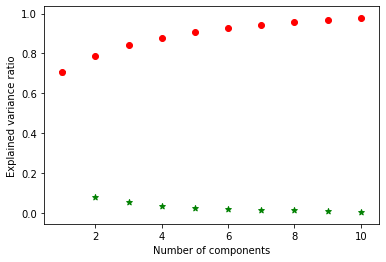

In [48]:
pca_model = display_PCA(10)

In [49]:
import seaborn as sns

In [50]:
corr = sensors_df_akima.corr(method='pearson')

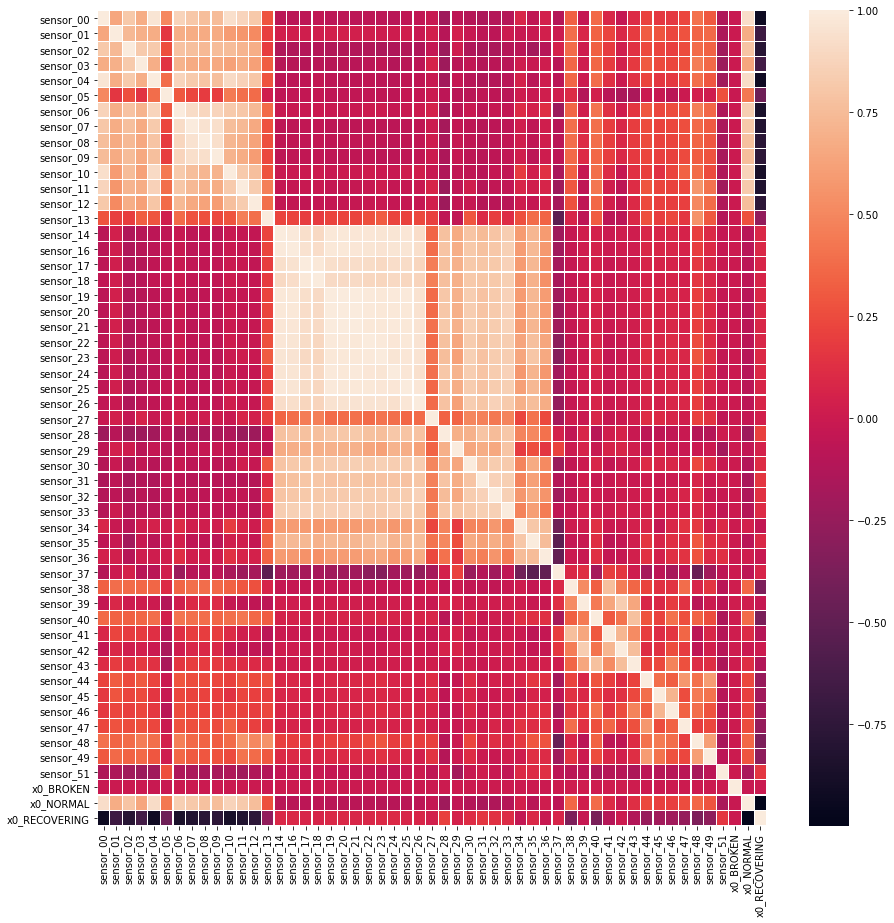

In [51]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr, linewidths=.2)

In [52]:
sensors_df_akima.head(2)

,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,x0_BROKEN,x0_NORMAL,x0_RECOVERING
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,201.3889,0.0,1.0,0.0
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.31076,634.375,76.45975,13.41146,16.13136,15.56713,...,39.6412,65.68287,50.92593,38.19444,157.9861,67.70834,201.3889,0.0,1.0,0.0


In [53]:
def grouper(table, column_name):
    table_1 = table[column_name]
    grouper = (table_1 != table_1.shift()).cumsum()
    return grouper

In [54]:
sensors_df_akima['normal_time'] = sensors_df_akima.groupby(grouper(sensors_df_akima, 'x0_NORMAL'))['x0_NORMAL'].cumsum()
sensors_df_akima['broken_time'] = sensors_df_akima.groupby(grouper(sensors_df_akima, 'x0_BROKEN'))['x0_BROKEN'].cumsum()
sensors_df_akima['recovering_time'] = sensors_df_akima.groupby(grouper(sensors_df_akima, 'x0_RECOVERING'))['x0_RECOVERING'].cumsum()

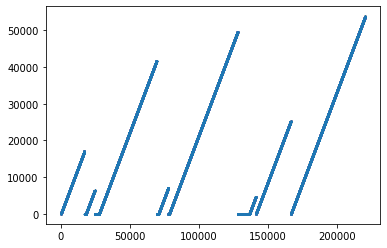

In [55]:
plt.scatter(x=np.arange(start=0, stop=len(sensors_df_akima)),
           y=sensors_df_akima['normal_time'],
           s=.2)

In [56]:
difference = sensors_df_akima['broken_time'].diff()
difference.loc[difference==1]

17155     1.0
24510     1.0
69318     1.0
77790     1.0
128040    1.0
141131    1.0
166440    1.0
Name: broken_time, dtype: float64

In [57]:
print('Data covers: ' + str(int(len(sensors_df_akima)/60/24)) + ' days.')

Data covers: 153 days.


Whole dataset covers 153 days. </br>
Lets try to classify, whether pump will brake in the next day.

In [58]:
def add_broken_flag(df, n):
    """Add flag to the datasset to indicate that failure will be in [n] days"""
    num_of_periods = n*24*60
    col_name = 'fail_in_' + str(n) + '_days'
    broken_index = df.loc[df['x0_BROKEN']==1].index
    df[col_name] = df['x0_BROKEN']
    for i in broken_index:
        df.loc[(int(i)-200): i, col_name] = 1
    return df

In [59]:
sensors_df_akima = add_broken_flag(sensors_df_akima, 1)
sensors_df_akima = add_broken_flag(sensors_df_akima, 3)

**Split into train, and test set** </br>
Because the data we're dealing with is time-series like, we cannot simply apply random train - test split. </br>
This requires split in *time-dependent* manner, so that model is not trained on data that will come in the future. </br>


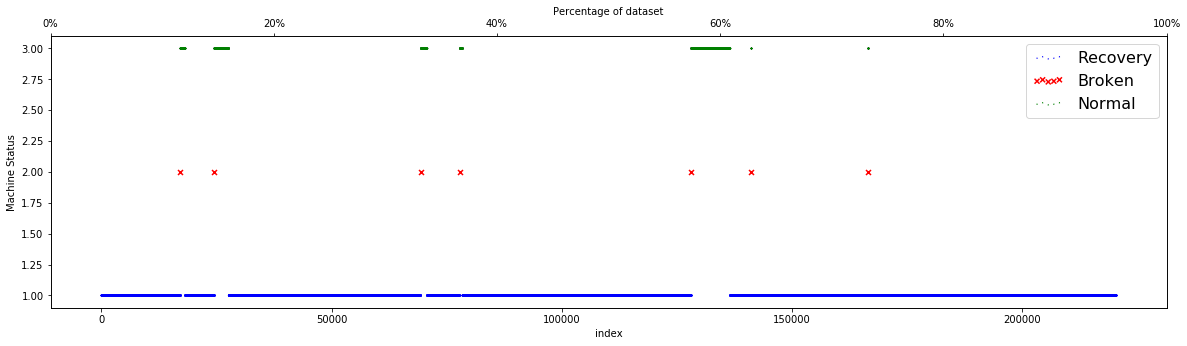

In [60]:
fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(111)
colors = ['b', 'r', 'g']
plot_1 = ax1.scatter(machine_status.index, machine_status.where(machine_status['machine_status']==1), s=0.1, c=colors[0], marker='x')
plot_2 = ax1.scatter(machine_status.index, machine_status.where(machine_status['machine_status']==2), s=25, c=colors[1], marker='x')
plot_3 = ax1.scatter(machine_status.index, machine_status.where(machine_status['machine_status']==3), s=0.1, c=colors[2], marker='x')
ax1.set_xlabel('index')
ax1.set_ylabel('Machine Status')

ax1.legend((plot_1, plot_2, plot_3),
           ('Recovery', 'Broken', 'Normal'),
           scatterpoints=5,
           loc='top right',
           ncol=1,
           fontsize=16)

ax2 = ax1.twiny()
ax2.set_xlabel('Percentage of dataset')
ax2.set_xticklabels(['0%','20%','40%', '60%', '80%', '100%'])
plt.show()

In [61]:
#drop some unnecessary columns
try:
    sensors_df_akima.drop(['timestamp'], axis=1, inplace=True)
except KeyError as e:
    print("Column does not exist:  ", str(e))
    

We divide data into three sets: train(55%), validation(25%) and test(20%)

In [62]:
df_train = sensors_df_akima.copy()
df_validation = sensors_df_akima.copy()
df_test = sensors_df_akima.copy()

In [63]:
df_train = df_train[df_train.index <= round(len(sensors_df_akima)*0.55)]
df_validation = df_validation[(df_validation.index > round(len(sensors_df_akima)*0.55)) & (df_validation.index <= round(len(sensors_df_akima)*0.8))]
df_test = df_test[df_test.index > round(len(sensors_df_akima)*0.8)]

In [64]:
print('Size of: \n train set: {} \n validation set: {} \n test set {}'.format(len(df_train), len(df_validation), len(df_test)))

Size of: 
 train set: 121177 
 validation set: 55080 
 test set 44063


**Apply min max scaling**

In [65]:
from sklearn.preprocessing import MinMaxScaler
min_max = MinMaxScaler()

In [66]:
col_names = sensors_df_akima.columns.tolist()

In [67]:
df_train_norm = pd.DataFrame(min_max.fit_transform(df_train), columns=col_names, index=df_train.index)
df_validation_norm = pd.DataFrame(min_max.fit_transform(df_validation), columns=col_names, index=df_validation.index)
df_test_norm = pd.DataFrame(min_max.fit_transform(df_test), columns=col_names, index=df_test.index)

**Represent data as moving widnow in order to apply it into the model**

In [69]:
df_train_norm.head(2)

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,...,sensor_49,sensor_51,x0_BROKEN,x0_NORMAL,x0_RECOVERING,normal_time,broken_time,recovering_time,fail_in_1_days,fail_in_3_days
0,0.976786,0.739583,0.855233,0.872093,0.792223,0.764598,0.626734,0.686154,0.726412,0.707483,...,0.134314,0.176365,0.0,1.0,0.0,0.000023,0.0,0.0,0.0,0.0
1,0.976786,0.739583,0.855233,0.872093,0.792223,0.764598,0.626734,0.686154,0.726412,0.707483,...,0.134314,0.176365,0.0,1.0,0.0,0.000047,0.0,0.0,0.0,0.0


In [70]:
# Let's take for a sequence length 60 periods. It sums up to 1 hour.
sequence_len = 60

In [71]:
df_train_norm_data = df_train_norm.drop(['fail_in_1_days', 'fail_in_3_days'], axis=1)
df_train_norm_label = df_train_norm['fail_in_1_days']

In [72]:
def generate_sequence(sequence_len, df):
    data_matrix = df.values
    for i in range(0, len(df) - sequence_len):
        yield data_matrix[i:sequence_len+i, :]

In [73]:
seq_gen = [next(generate_sequence(sequence_len, df_train_norm_data)) for i in range(0, len(df_train_norm_data) - sequence_len)]

In [74]:
seq_array = np.stack(seq_gen).astype(np.float32)

In [75]:
seq_array_shape = seq_array.shape
print('Input data into model: \n number of sequences: {} \n number of samples in sequence: {} \n number of features: {}'.
      format(seq_array_shape[0], seq_array_shape[1], seq_array_shape[2]))

Input data into model: 
 number of sequences: 121117 
 number of samples in sequence: 60 
 number of features: 56


In [76]:
def generate_label(sequence_len, df):
    data_matrix = df.values
    num_of_elements = data_matrix.shape[0]
    return data_matrix[sequence_len:num_of_elements]

In [77]:
label_array = generate_label(sequence_len, df_train_norm_label)

In [78]:
label_array = label_array.reshape(label_array.shape[0], 1)

In [79]:
label_array.shape

(121117, 1)

Lets preserve created training and testing arrays

In [80]:
np.save('seq_array', seq_array)
np.save('label_array', label_array)

# Model building </br>
Output layer will contain one node and sigmoid activation function as the task is binary classification. </br>
Dropout will be applied to control overfitting.

In [81]:
from keras import Sequential
import keras
import keras_metrics

Using TensorFlow backend.


In [82]:
from keras.layers import Dense, Dropout, LSTM, GRU

In [83]:
model_path = 'binary_model.h5'

In [84]:
model = Sequential()

In [85]:
number_of_features = seq_array_shape[2]
number_outcome = label_array.shape[1]

In [86]:
model.add(LSTM(
            input_shape=(sequence_len , number_of_features),
            units=100,
            return_sequences=True))

model.add(Dropout(0.2))

model.add(LSTM(
            units=50,
            return_sequences=False))

model.add(Dropout(0.2))

model.add(Dense(
            units=number_outcome,
            activation='sigmoid'))

In [87]:
model.compile(
            loss='binary_crossentropy',
            optimizer='adam',
            metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

In [88]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 100)           62800     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 93,051
Trainable params: 93,051
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
model.fit(x=seq_array,
          y=label_array,
          epochs=10,
          batch_size=600,
          validation_split=0.1,
          verbose=1,callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                             min_delta=0,
                                                             patience=5,
                                                             verbose=0, 
                                                             mode='auto')])